# 🍔👁 Food Vision: fine tunning Efficentnet with food_101 dataset

In these notebook I`m going to build a transfer learning model which beat the original results of the [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) with only 10% of the data for training (25250 training images and 7570 testing images). After that, I'm going to reproduce the same model with all of the data from the Food101 dataset.
The goal to achive for these project is **beat [DeepFood](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment)**, a 2016 paper which used a Convolutional Neural Network **trained for 2-3 days to achieve 77.4% top-1 accuracy**.

In these project you can see the following steps:
- 1. Creation of a small CNN to see how they works
- 2. Transfer Learning with the [EfficientNet](https://arxiv.org/abs/1905.11946) model, a state of the art computer vision architecture trained with [ImageNet (ILSVRC-2012-CLS)](http://www.image-net.org/), the gold standard of computer vision benchmarks. In these case, I'm going to use the 10% of the data of the Food_101 dataset.
- 3. Fine tune the [EfficientNet](https://arxiv.org/abs/1905.11946) model with 10 % of the data.
- 4. Develop the same EfficentNet model as above but with the **100% of the Food_101 dataset**.


In [3]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2024-11-28 19:34:19.807547


- In the repository you can download the *helper_functions.py* file, with developed functions that are so useful for these and other projects of Convolutional Neural Networks

In [4]:
# Get helper functions file
import os 

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/Garcialejan/Computer_vision_food_classification/refs/heads/main/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

[INFO] 'helper_functions.py' already exists, skipping download.


In [5]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import plot_loss_curves, walk_through_dir, create_checkpoint_callback

- Now, I'm going to import some of the modules that we need to run the code, check the tensorflow version and check if we are using the GPU for run our models.

In [6]:
import tensorflow as tf

In [7]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


In [8]:
# Get GPU name
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 4060 Ti (UUID: GPU-0cb8d0d0-b8f3-ea57-552f-290eacf87dec)


In [9]:
# We reduce the logs with:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Only shows warnings and errors

# Models with 10 % of the data

## 1. Loading the data.

In [10]:
train_dir = "/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/train"
test_dir = "/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/test"

In [11]:
walk_through_dir("/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/")

There are 2 directories and 0 images in '/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/'.
There are 101 directories and 0 images in '/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/test'.
There are 0 directories and 75 images in '/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/test/bibimbap'.
There are 0 directories and 75 images in '/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/test/donuts'.
There are 0 directories and 75 images in '/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/test/sushi'.
There are 0 directories and 75 images in '/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/data/101_food_classes_10_percent/test/beef_carpaccio'.
There are 0 directories and 75 images

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image_direct(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir + "/" +target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (512, 512, 3)


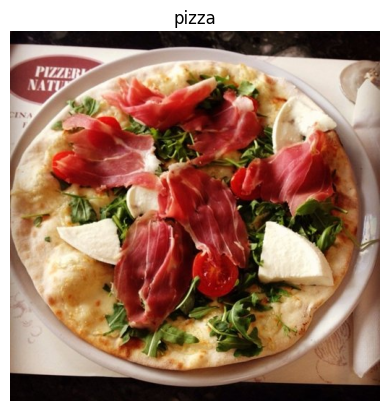

In [13]:
img = view_random_image_direct(target_dir=train_dir, target_class="pizza")

In [14]:
img

array([[[44, 29, 32],
        [31, 19, 21],
        [20,  8, 10],
        ...,
        [ 4,  3,  1],
        [ 4,  3,  1],
        [ 4,  3,  1]],

       [[39, 24, 27],
        [27, 15, 17],
        [15,  5,  6],
        ...,
        [ 5,  4,  2],
        [ 6,  5,  3],
        [ 6,  5,  3]],

       [[29, 17, 19],
        [20,  8, 10],
        [11,  1,  2],
        ...,
        [ 8,  4,  3],
        [ 9,  5,  4],
        [ 9,  5,  4]],

       ...,

       [[ 7,  1,  1],
        [ 7,  1,  1],
        [ 7,  1,  1],
        ...,
        [ 4,  0,  1],
        [ 4,  0,  1],
        [ 5,  1,  2]],

       [[ 6,  0,  0],
        [ 6,  0,  0],
        [ 7,  1,  1],
        ...,
        [ 4,  0,  1],
        [ 4,  0,  1],
        [ 5,  1,  2]],

       [[ 7,  1,  1],
        [ 7,  1,  1],
        [ 7,  1,  1],
        ...,
        [ 4,  0,  1],
        [ 4,  0,  1],
        [ 5,  1,  2]]], dtype=uint8)

In [15]:
print(img.min(), img.max())

0 255


- Looking at the image shape more closely, you'll see it's in the form `(Width, Height, Colour Channels)`
- All of the values in the `img` array are between 0 and 255. This is because that's the possible range for red, green and blue values.
- To work with normalize data, we are going to use one of the most common preprocessing steps for working with images, which is to **scale** (also referred to as **normalize**) the pixel values by dividing the image arrays by 255. We are going to do this step of normalize the data in a layer using the Sequential API of tensorflow.

- Let's use the [`image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) function to turn our images and labels into a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset), a TensorFlow datatype which allows for us to pass it directory to our model.

In [16]:
# Create data inputs 
IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # Multiclass classification problem
                                                                            batch_size=32, # To avoid memory problems
                                                                            shuffle = True) 

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 25250 files belonging to 101 classes.


I0000 00:00:1732818863.417558   23891 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13689 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 7575 files belonging to 101 classes.


In [17]:
# Check the training data datatype
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

- The `batch_size` is `None` due to it only being used during model training. You can think of `None` as a placeholder waiting to be filled with the `batch_size` parameter from `image_dataset_from_directory()`.

In [18]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

- I'm going to create a [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callbacks to save the progress during training. This means I could experiment with further training later without having to train from scratch every time.
- This maybe is making non sense to you becouse I'm developing a small CNN, however this callback will be useful when we see the EfficentNet transfer learning and fine tunning models.  

In [19]:
# Create checkpoint callback to save model for later use
checkpoint_path = "/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/101_classes_10_percent_data_model/"
checkpoint_name = "model1_checkpoint.weights.h5"

chk_callback_model1 = tf.keras.callbacks.ModelCheckpoint(checkpoint_path + checkpoint_name,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

## 2. First CNN: base_model

In [20]:
from tensorflow import keras
from tensorflow.keras import layers

model_1 = tf.keras.models.Sequential([
    layers.Rescaling(1./255,
                     input_shape=(224, 224, 3)),
    layers.Conv2D(filters=10,
                  kernel_size=3, 
                  activation="relu"),
    layers.Conv2D(10, 3, activation="relu"),
    layers.MaxPool2D(pool_size=2, padding="valid"),
    layers.Conv2D(10, 3, activation="relu"),
    layers.Conv2D(10, 3, activation="relu"),
    layers.MaxPool2D(2),
    layers.Flatten(),
    layers.Dense(len(train_data_10_percent.class_names), activation="softmax")
])

/home/alejandro/anaconda3/envs/tensorflow_env/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
# Compile the model
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [22]:
# Fit the model
history_1 = model_1.fit(train_data_10_percent,
                        epochs=5,
                        validation_data=test_data_10_percent,
                        callbacks=[chk_callback_model1])

Epoch 1/5


I0000 00:00:1732818865.597537   24019 service.cc:148] XLA service 0x7f6e00016e10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732818865.597591   24019 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-11-28 19:34:25.659594: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732818865.755617   24019 cuda_dnn.cc:529] Loaded cuDNN version 90300


  8/790 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.0031 - loss: 0.2854    

I0000 00:00:1732818868.496985   24019 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


787/790 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0261 - loss: 0.0637

2024-11-28 19:34:41.782081: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_603', 432 bytes spill stores, 336 bytes spill loads

2024-11-28 19:34:42.013997: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_714', 612 bytes spill stores, 612 bytes spill loads

2024-11-28 19:34:42.053612: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_714', 536 bytes spill stores, 536 bytes spill loads



790/790 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.0262 - loss: 0.0637 - val_accuracy: 0.0548 - val_loss: 0.0533
Epoch 2/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.1145 - loss: 0.0496 - val_accuracy: 0.0929 - val_loss: 0.0526
Epoch 3/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.3259 - loss: 0.0388 - val_accuracy: 0.0650 - val_loss: 0.0721
Epoch 4/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.7118 - loss: 0.0191 - val_accuracy: 0.0488 - val_loss: 0.1144
Epoch 5/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9542 - loss: 0.0049 - val_accuracy: 0.0557 - val_loss: 0.1732


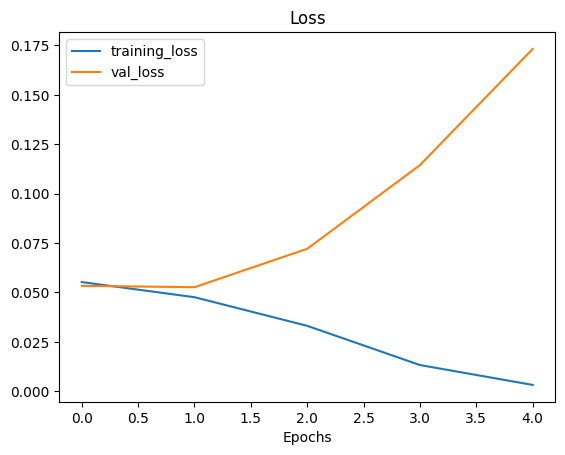

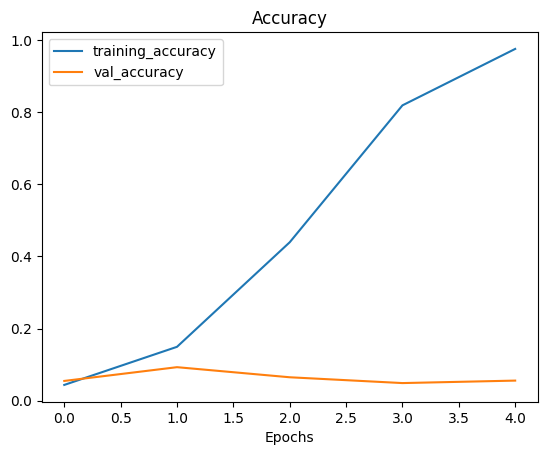

In [23]:
# How does the model go
plot_loss_curves(history_1)

- Well, as you can see, **overfitting** has come to the party. Let's try something to avoid it.
- For the other hand, I'm going to add some extra features to the CNN to get a better accuracy value

In [ ]:
model_2 = tf.keras.models.Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),  
    layers.Conv2D(32, 3, activation="relu"),             # More filters in the initial layers
    layers.MaxPool2D(pool_size=2),
    layers.Conv2D(64, 3, activation="relu"),             # We add progressively more filters
    layers.MaxPool2D(pool_size=2),
    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPool2D(pool_size=2),
    layers.Flatten(),
    layers.Dropout(0.5),                                 # Dropout to avoid overfitting
    layers.Dense(128, activation="relu"),                # New fully connected layer
    layers.Dropout(0.5),                                 # More dropout to avoid overfitting
    layers.Dense(len(train_data_10_percent.class_names), activation="softmax")  # Salida softmax
])

/home/alejandro/anaconda3/envs/tensorflow_env/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data_10_percent,
                        epochs=5,
                        validation_data=test_data_10_percent)

Epoch 1/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step - accuracy: 0.0111 - loss: 0.1179 - val_accuracy: 0.0193 - val_loss: 0.0564
Epoch 2/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.0114 - loss: 0.0609 - val_accuracy: 0.0197 - val_loss: 0.0549
Epoch 3/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.0207 - loss: 0.0592 - val_accuracy: 0.0391 - val_loss: 0.0537
Epoch 4/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.0309 - loss: 0.0578 - val_accuracy: 0.0474 - val_loss: 0.0533
Epoch 5/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.0397 - loss: 0.0567 - val_accuracy: 0.0529 - val_loss: 0.0528


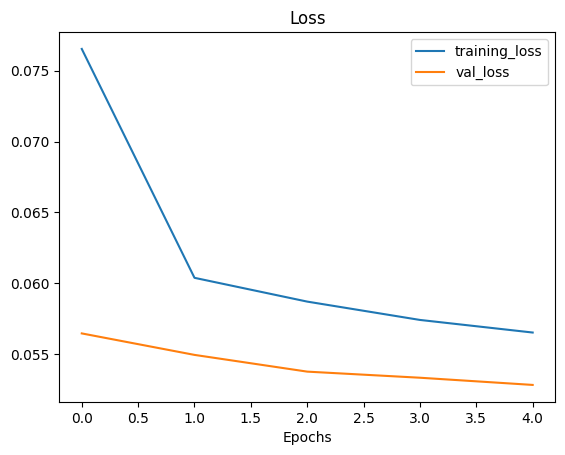

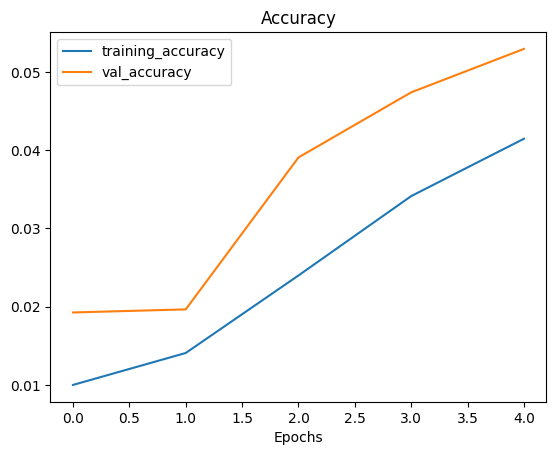

In [26]:
plot_loss_curves(history_2)

- I have reduced the overfitting, however I'm far away from my goal of getting an accuracy similar to the [DeepFood](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment) project.

- No problem, to solve this I am going to use transfer learning and fine tunning with the [EfficientNet](https://arxiv.org/abs/1905.11946) model.

## 3. Transfer learning with EfficientNet

- Now, I'm going to use the [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) module that contains a series of already trained (on ImageNet) computer vision models as well as the Keras Functional API to construct our model. 
- In particular, I'm going to use the [EfficientNet](https://arxiv.org/abs/1905.11946) model setting the `include_top` parameter to `False` (we do this because we're going to create our own top, which are the output layers for the model).
- Set the base model's `trainable` attribute to `False` to freeze all of the weights in the pre-trained model.

In [34]:
# Reload the images

IMG_SIZE = (224, 224) 
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # Multiclass classification problem
                                                                            batch_size=32, # To avoid memory problems
                                                                            shuffle = True) 

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 25250 files belonging to 101 classes.
Found 7575 files belonging to 101 classes.


In [35]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(include_top=False)
# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

### 3.1 Adding data augmentation and normalize images

**Data augmentation** is the process of altering our training data, leading to it having more diversity and in turn allowing our models to learn more generalizable patterns. Altering might mean adjusting the rotation of an image, flipping it, cropping it or something similar. Doing this simulates the kind of data a model might be used on in the real world.

- To use data augmentation right within our model we'll create a Keras Sequential model consisting of only data preprocessing layers, we can then use this Sequential model within another Functional model.

In [36]:
data_augmentation = keras.Sequential([
  layers.Input(shape = (224, 224, 3)),
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # layers.Rescaling(1./255)
], name ="data_augmentation")

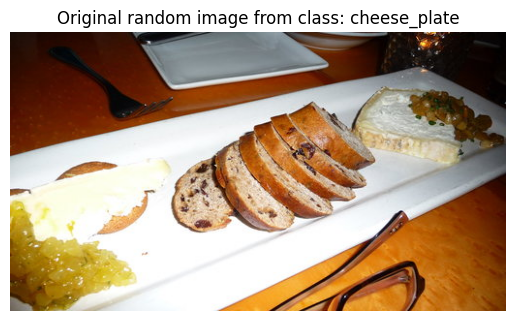

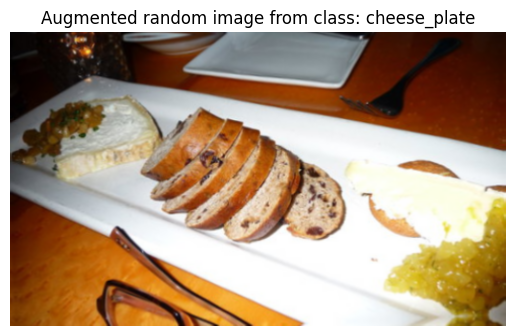

In [37]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_10_percent.class_names) # choose a random class
target_dir = train_dir + "/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image

plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()

plt.imshow(tf.squeeze(augmented_img)/255) # eliminate te batch dimension
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

- The `EfficientNetV2` models in the `tf.keras.applications` module do not require images to be normalized (pixel values between 0 and 1) on input, where as many of the other models do

In [ ]:
# We are going to see the summary of the EfficentNetV2 model
# You can see that the 3 layer is a normalization layer
base_model.summary()

### 3.2 Model creation and trainning

In [42]:
def create_transfer_leraning_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                                   output_shape: int = 101,
                                   learning_rate: float = 0.001,
                                   training: bool = False) -> tf.keras.Model:
    """
    Create a model based on EfficientNetV2B3 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """

    # Create base model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(include_top=False)
    base_model.trainable = training

    # Setup model input and outputs with data augmentation built-in
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs)
    x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model

In [43]:
# Create an instance of model_3
model_3 = create_transfer_leraning_model()

In [44]:
model_3.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b3 (Functional)  │ (None, None, None,     │    12,930,622 │
│                                 │ 1536)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       155,237 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,085,859 (49.92 MB)

 Trainable params: 155,237 (606.39 KB)

 Non-trainable params: 12,930,622 (49.33 MB)

In [58]:
# Create checkpoint callback to save model for later use
checkpoint_path_model3 = "/home/alejandro/proyectos_tensorflow/Computer_vision_food_classification/101_classes_10_percent_data_model/"
checkpoint_name_model3 = "model3_checkpoint.weights.h5"

chk_callback_model3 = create_checkpoint_callback(checkpoint_path_model3,
                                                 checkpoint_name_model3)

In [49]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent = model_3.fit(train_data_10_percent,
                                 epochs=initial_epochs,
                                 validation_data=test_data_10_percent,
                                 validation_steps=int(0.25 * len(test_data_10_percent)), # do less steps per validation (quicker)
                                 callbacks = [chk_callback_model3])

Epoch 1/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 292s 369ms/step - accuracy: 0.3543 - loss: 2.8920 - val_accuracy: 0.5217 - val_loss: 1.8678
Epoch 2/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 187s 237ms/step - accuracy: 0.5231 - loss: 1.8808 - val_accuracy: 0.5551 - val_loss: 1.7171
Epoch 3/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 152s 193ms/step - accuracy: 0.5655 - loss: 1.6975 - val_accuracy: 0.5858 - val_loss: 1.6284
Epoch 4/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 122s 155ms/step - accuracy: 0.5802 - loss: 1.6201 - val_accuracy: 0.5964 - val_loss: 1.5966
Epoch 5/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.5998 - loss: 1.5263

/home/alejandro/anaconda3/envs/tensorflow_env/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


790/790 ━━━━━━━━━━━━━━━━━━━━ 103s 131ms/step - accuracy: 0.5998 - loss: 1.5263 - val_accuracy: 0.6957 - val_loss: 1.2813


In [59]:
# Evaluate on the test data
results_model_3= model_3.evaluate(test_data_10_percent)
results_model_3

237/237 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.6073 - loss: 1.5599


[1.5631996393203735, 0.6063366532325745]

In [60]:
# Load in saved model weights and evaluate model
model_3.load_weights(checkpoint_path_model3 + checkpoint_name_model3)
loaded_weights_model3_results = model_2.evaluate(test_data_10_percent)

237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0560 - loss: 0.0528


In [ ]:
# If the results from our native model and the loaded weights are the same, this should output True
results_model_3 == loaded_weights_model3_results

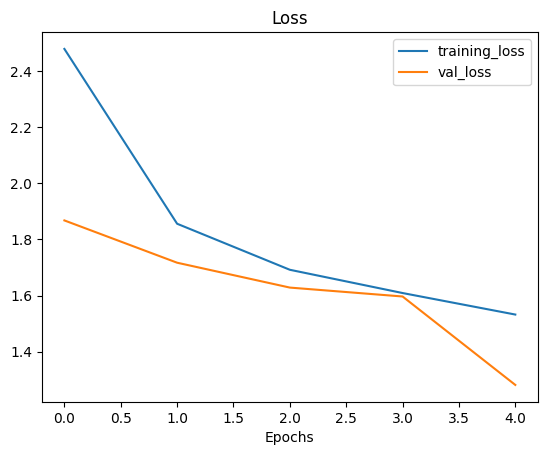

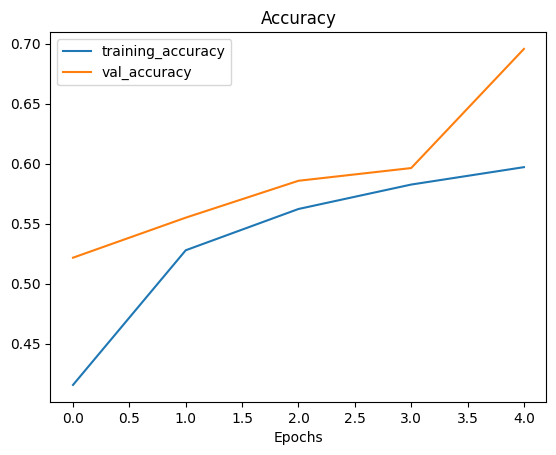

In [51]:
# Plot model loss curves
plot_loss_curves(history_10_percent)

Well it looks like **we just beat our baseline (the results from the original Food101 paper) with 10% of the data**! In under 5-minutes... that's the power of deep learning and more precisely, transfer learning: leveraging what one model has learned on another dataset for our own dataset.

How do the loss curves look?